In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from importlib.metadata import version

print("Pandas version: " + str(pd.__version__))
print("Numpy version: " + str(np.__version__))
print("Fastparquet version: " + str(version("fastparquet")))
print("Matplotlib version: " + str(version("matplotlib")))
print("Seborn version: " + str(sns.__version__))

Pandas version: 2.3.3
Numpy version: 2.3.4
Fastparquet version: 2024.11.0
Matplotlib version: 3.10.7
Seborn version: 0.13.2


In [2]:
df = pd.read_parquet('../data/temp/nystate_flu_discharges_2024.parquet', engine = "fastparquet")

df.shape

(7213, 21)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7213 entries, 0 to 7212
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   health_service_area                  7213 non-null   object
 1   hospital_county                      7213 non-null   object
 2   permanent_facility_id                7213 non-null   object
 3   age_group                            7213 non-null   object
 4   zip_code                             7213 non-null   object
 5   gender                               7213 non-null   object
 6   race                                 7213 non-null   object
 7   ethnicity                            7213 non-null   object
 8   length_of_stay                       7213 non-null   int64 
 9   type_of_admission                    7213 non-null   object
 10  patient_disposition                  7213 non-null   object
 11  ccsr_procedure_description           7213 n

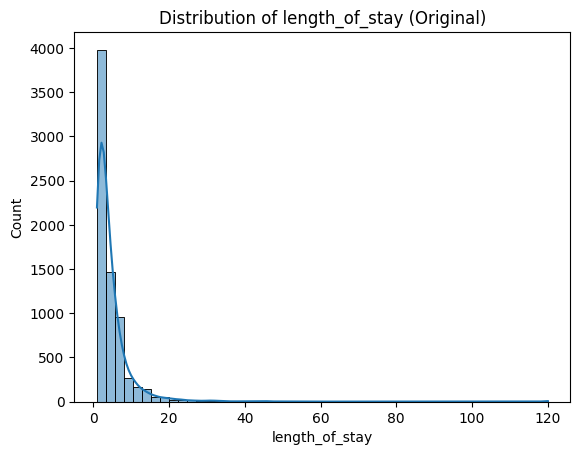

In [4]:
# distribution of target
sns.histplot(df['length_of_stay'], kde = True, bins = 50)
plt.title("Distribution of length_of_stay (Original)")
plt.show()

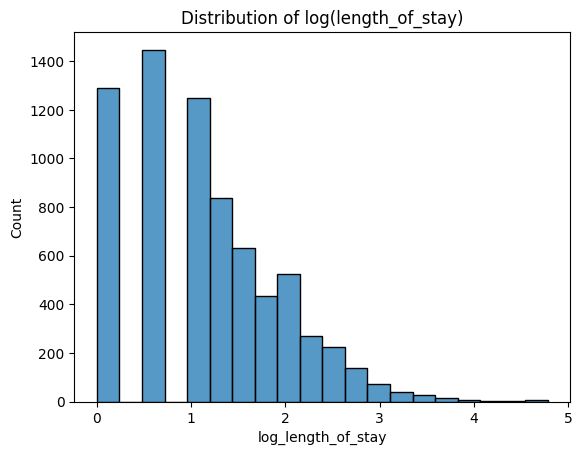

In [5]:
# transform using the natural log
df['log_length_of_stay'] = np.log(df['length_of_stay'])

# distribution of transformed target
sns.histplot(df['log_length_of_stay'], bins = 20)
plt.title("Distribution of log(length_of_stay)")
plt.show()

Facility and location features:
- health_service_area
- hospital_county
- operating_certificate_number
- permanent_facility_id
- facility_name
- zip_code

Demographic features:
- age_group
- gender
- race
- ethnicity

Admission-related features:
- type_of_admission
- patient_disposition
- emergency_department_indicator

Clinical features:
- ccsr_procedure_description
- apr_drg_description
- apr_mdc_description
- apr_severity_of_illness_description
- apr_risk_of_mortality
- apr_medical_surgical_description

Payment / Payer features:
- payment_typology_1
- payment_typology_2
- payment_typology_3

`total_charges` and `total_cost` were excluded from the predictive features because they are outcomes of hospitalization that are determined after discharge. Including them would constitute target leakage, as these variables are highly correlated with and partly derived from the length of stay itself. The goal of this project is to model and predict LoS using information available at or near the time of the hospital stay.

`apr_drg_description`, `apr_mdc_description`, `apr_severity_of_illness_description`, `apr_risk_of_mortality`, `apr_medical_surgical_description` may not typically be determined until after the stay however, in this case, they will be used as proxies for clinical diagnoses at the time of treatment.

In [6]:
categorical_cols = ['health_service_area', 'hospital_county', 'permanent_facility_id', 
                    'age_group', 'zip_code', 'gender', 
                    'race', 'ethnicity', 'type_of_admission', 
                    'patient_disposition', 'ccsr_procedure_description', 'apr_drg_description',
                    'apr_mdc_description', 'apr_severity_of_illness_description', 'apr_risk_of_mortality',
                    'apr_medical_surgical_description', 'payment_typology_1', 'payment_typology_2', 
                    'payment_typology_3', 'emergency_department_indicator']

target_col = ['length_of_stay']

In [7]:
# print frequency, mean and median LoS for all categories in each feature
for col in categorical_cols:
    print(f"--- {col} ---")
    freq = df[col].value_counts(dropna = False)
    percent = df[col].value_counts(normalize = True, dropna = False) * 100
    mean_los = df.groupby(col)['length_of_stay'].mean()
    median_los = df.groupby(col)['length_of_stay'].median()

    summary = pd.DataFrame({
        'Count': freq, 
        'Percent': percent.round(2),
        'Mean LoS': mean_los.round(3),
        'Median LoS': median_los.round(1)
    }).sort_values(by = 'Count', ascending = False)
    
    with pd.option_context('display.expand_frame_repr', False, 
                           'display.max_rows', None):
        print(summary, '\n')

--- health_service_area ---
                     Count  Percent  Mean LoS  Median LoS
health_service_area                                      
New York City         3463    48.01     4.708         3.0
Long Island           1242    17.22     4.354         3.0
Hudson Valley          773    10.72     4.837         4.0
Finger Lakes           493     6.83     5.509         4.0
Western NY             480     6.65     4.165         3.0
Capital/Adirondacks    340     4.71     4.688         3.0
Central NY             339     4.70     4.389         3.0
Southern Tier           77     1.07     3.896         3.0
NAA                      6     0.08     3.000         2.0 

--- hospital_county ---
                 Count  Percent  Mean LoS  Median LoS
hospital_county                                      
New York           977    13.54     4.821         3.0
Kings              835    11.58     5.377         4.0
Bronx              725    10.05     4.557         3.0
Nassau             699     9.69     4.

Many features have categories with a small number of discharges. Ideally, these should be combined with other categories based on domain knowledge and target similarity. For simplicity in this project, categories with fewer than 20 observations will be combined into an 'Other' group.

In [8]:
def create_small_group_mapping(df, feature, min_count = 20):
    """combine all small categories into 'Other'"""
    value_counts = df[feature].value_counts()
    small_categories = value_counts[value_counts < min_count].index.tolist()
    
    return {cat: 'Other' for cat in small_categories}

In [9]:
category_mappings = {}

category_mappings = {
    'health_service_area': {
        'Southern Tier': 'Southern Tier/Other',
        'NAA':           'Southern Tier/Other'        
    },
    'gender': {
        'F': 'F/U',
        'U': 'F/U'
    },
    'ethnicity': {
        'Multi-ethnic': 'Multi-ethnic/Unknown',
        'Unknown': 'Multi-ethnic/Unknown'        
    },
    'type_of_admission': {
        'Elective': 'Elective/Trauma/Other',
        'Trauma': 'Elective/Trauma/Other',
        'Not Available': 'Elective/Trauma/Other'
    },
    'payment_typology_1': {
        'Federal/State/Local/VA': 'Miscellaneous/Other',
        'Department of Corrections': 'Miscellaneous/Other'
    },
    'payment_typology_3': {
        'Medicare': 'Miscellaneous/Other',
        'Federal/State/Local/VA': 'Miscellaneous/Other',
        'Managed Care, Unspecified': 'Miscellaneous/Other'
    }
}

category_mappings['hospital_county'] = create_small_group_mapping(df, 'hospital_county', min_count = 20)
category_mappings['permanent_facility_id'] = create_small_group_mapping(df, 'permanent_facility_id', min_count = 20)
category_mappings['zip_code'] = create_small_group_mapping(df, 'zip_code', min_count = 20)
category_mappings['patient_disposition'] = create_small_group_mapping(df, 'patient_disposition', min_count = 20)
category_mappings['ccsr_procedure_description'] = create_small_group_mapping(df, 'ccsr_procedure_description', min_count = 20)
category_mappings['apr_drg_description'] = create_small_group_mapping(df, 'apr_drg_description', min_count = 20)

In [10]:
# apply all mappings at once
for feature, mapping in category_mappings.items():
    df[feature] = df[feature].replace(mapping)

In [11]:
# print frequency, mean and median LoS for all categories for each feature again
for col in categorical_cols:
    print(f"--- {col} ---")
    freq = df[col].value_counts(dropna = False)
    percent = df[col].value_counts(normalize = True, dropna = False) * 100
    mean_los = df.groupby(col)['length_of_stay'].mean()
    std_los = df.groupby(col)['length_of_stay'].std()
    min_los = df.groupby(col)['length_of_stay'].min()
    q1_los = df.groupby(col)['length_of_stay'].quantile(0.25)
    median_los = df.groupby(col)['length_of_stay'].median()
    q3_los = df.groupby(col)['length_of_stay'].quantile(0.75)
    max_los = df.groupby(col)['length_of_stay'].max()

    summary = pd.DataFrame({
        'Count': freq, 
        'Percent': percent.round(2),
        'Mean LoS': mean_los.round(3),
        'Std LoS': std_los.round(3),
        'Min LoS': min_los,
        'Q1 LoS': q1_los.round(1),
        'Median LoS': median_los.round(1),
        'Q3 LoS': q3_los.round(1),
        'Max LoS': max_los
    }).sort_values(by = 'Count', ascending = False)
    
    with pd.option_context('display.expand_frame_repr', False, 
                           'display.max_rows', None):
        print(summary, '\n')

--- health_service_area ---
                     Count  Percent  Mean LoS  Std LoS  Min LoS  Q1 LoS  Median LoS  Q3 LoS  Max LoS
health_service_area                                                                                 
New York City         3463    48.01     4.708    6.684        1     2.0         3.0     5.0      120
Long Island           1242    17.22     4.354    4.961        1     2.0         3.0     5.0       78
Hudson Valley          773    10.72     4.837    5.080        1     2.0         4.0     6.0       70
Finger Lakes           493     6.83     5.509    8.967        1     2.0         4.0     6.0      109
Western NY             480     6.65     4.165    3.721        1     2.0         3.0     5.0       35
Capital/Adirondacks    340     4.71     4.688    7.265        1     2.0         3.0     5.0      120
Central NY             339     4.70     4.389    4.024        1     2.0         3.0     5.0       39
Southern Tier/Other     83     1.15     3.831    2.575        1

Surgical inpatient stays have a much greater LoS than medical stays (mean LoS of 31.5 days versus 4.4 days).

The 'Other' All Patient Refined Diagnosis Related Group (APR DRG) category represents rare, complex cases including: major surgical procedures unrelated to principal diagnosis, ECMO, tracheostomy with prolonged mechanical ventilation, organ transplants, and severe infectious diseases. These cases have dramatically longer stays (mean LoS of 28.2 days vs 3-5 days for common respiratory diagnoses).

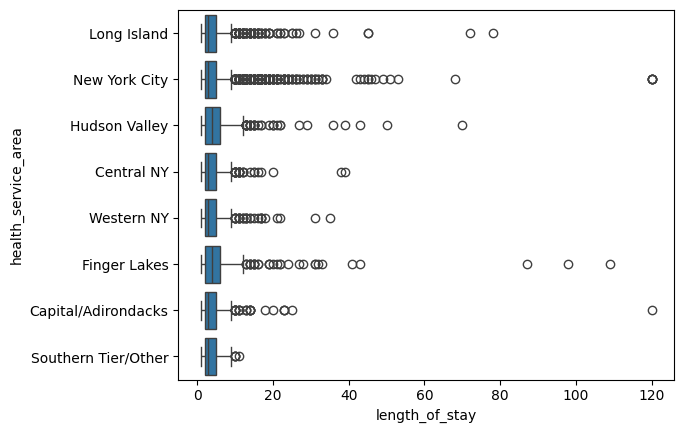

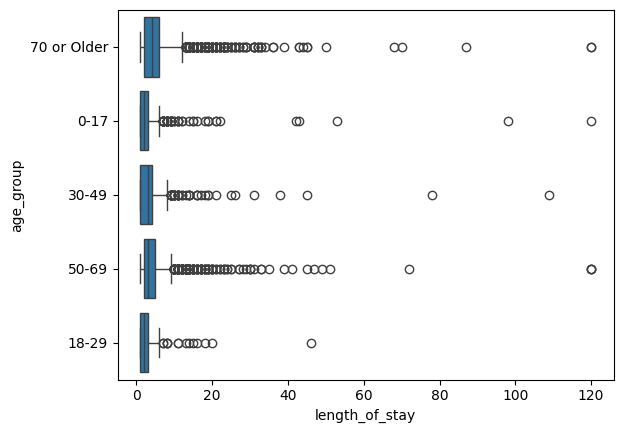

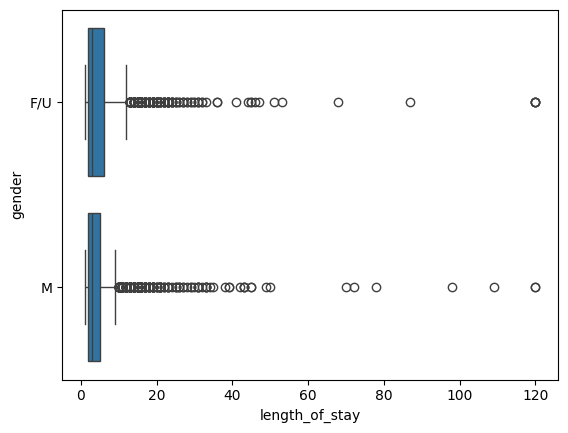

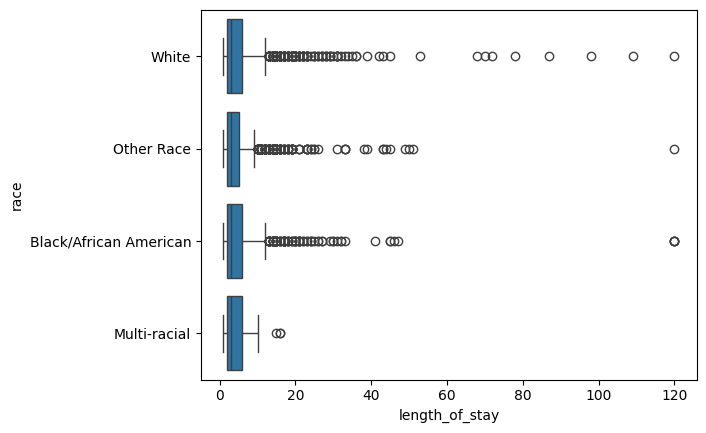

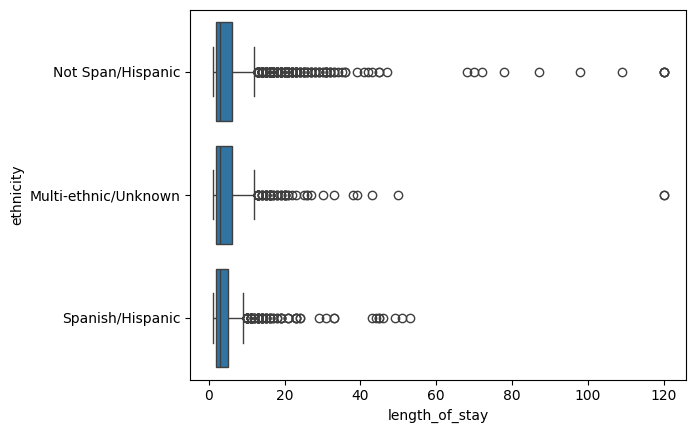

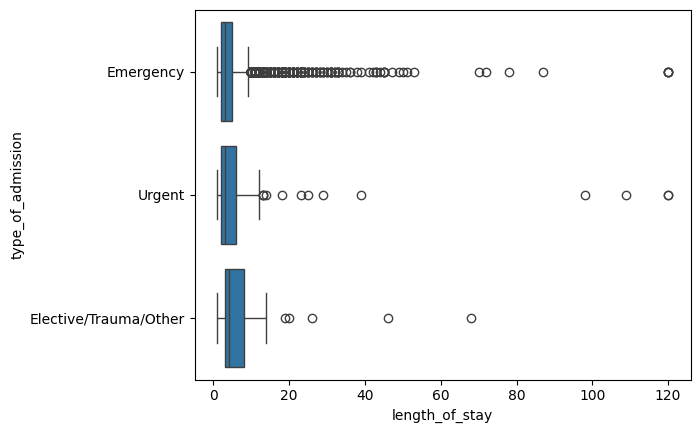

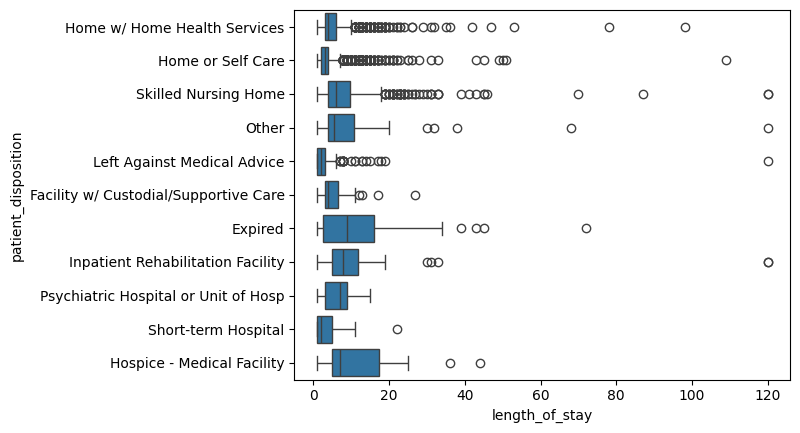

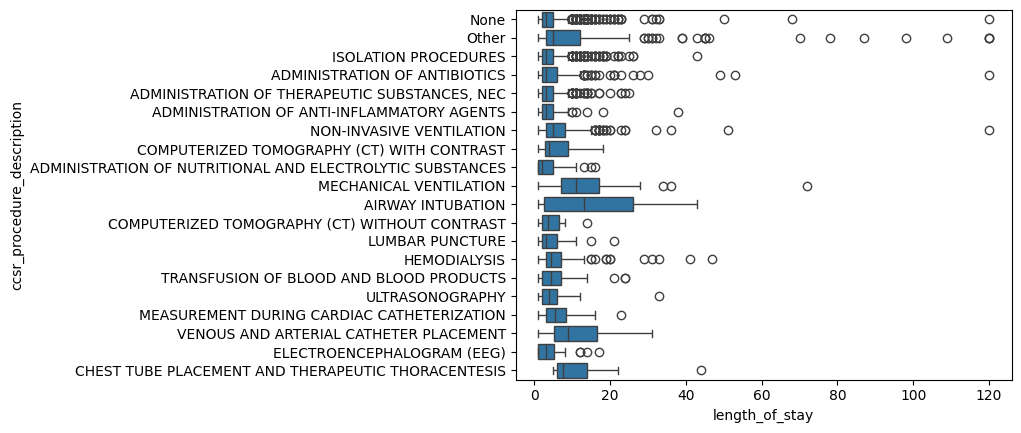

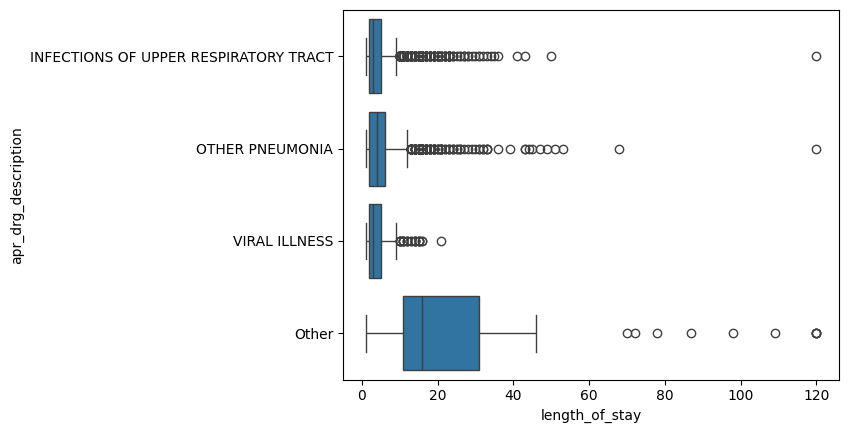

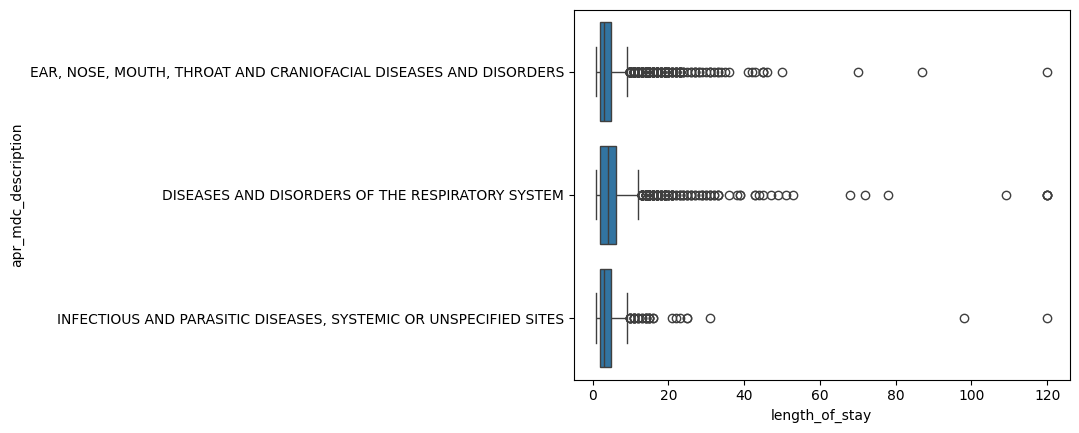

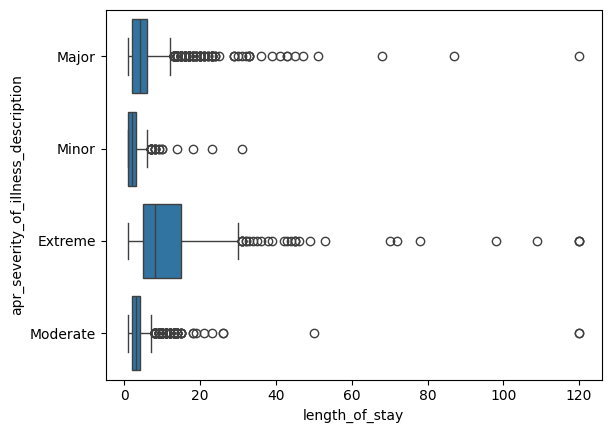

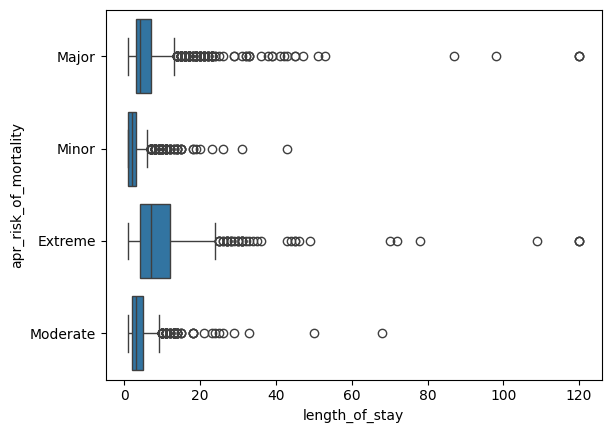

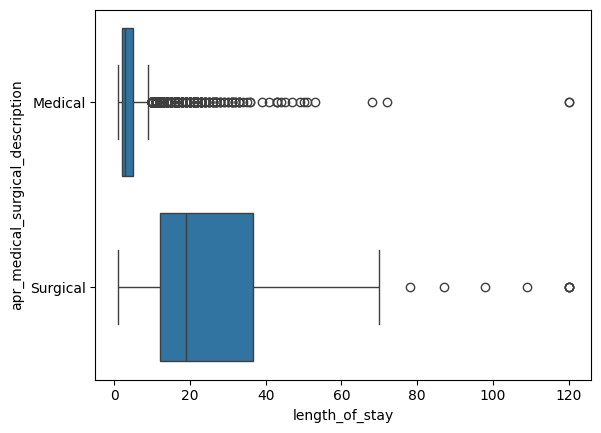

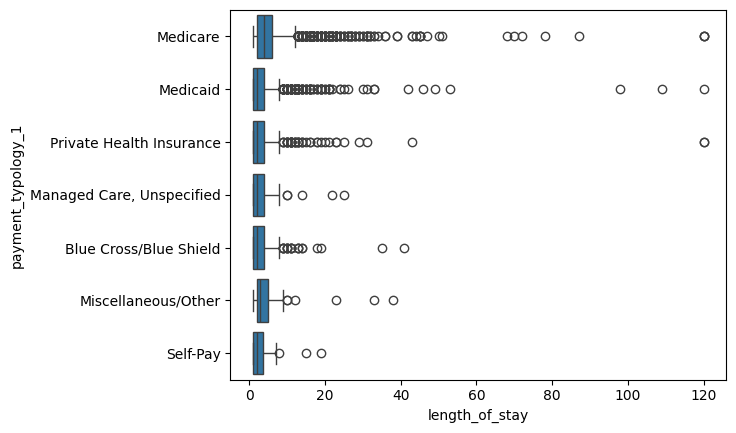

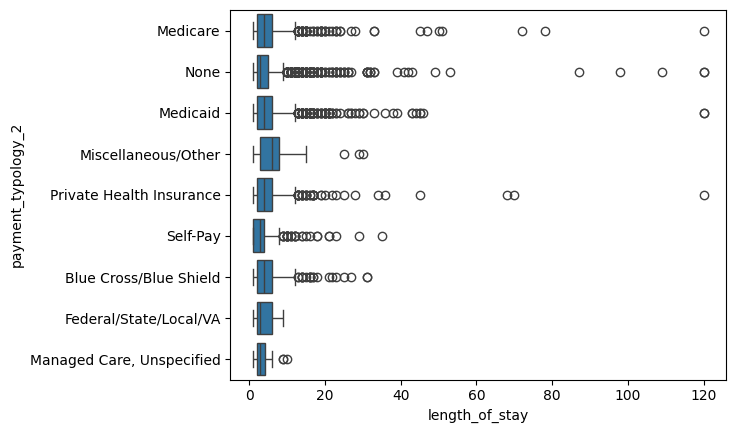

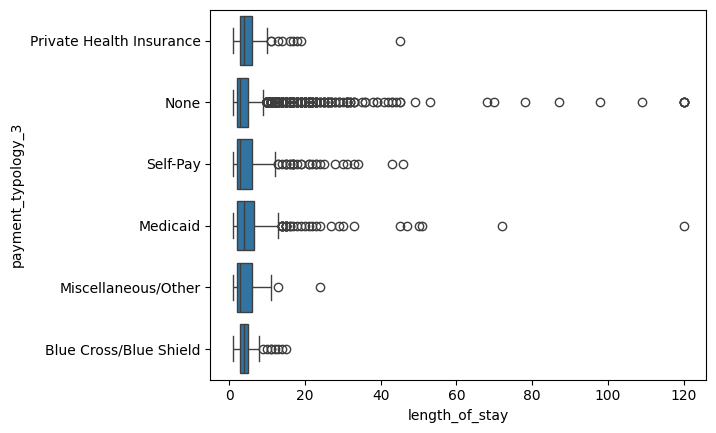

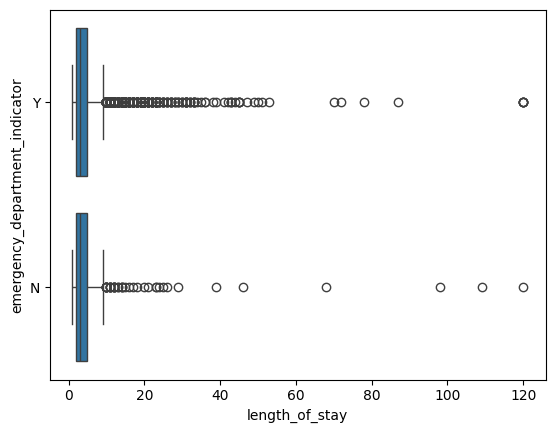

In [12]:
for col in ['health_service_area', 
                    'age_group', 'gender', 
                    'race', 'ethnicity', 'type_of_admission', 
                    'patient_disposition', 'ccsr_procedure_description', 'apr_drg_description',
                    'apr_mdc_description', 'apr_severity_of_illness_description', 'apr_risk_of_mortality',
                    'apr_medical_surgical_description', 'payment_typology_1', 'payment_typology_2', 
                    'payment_typology_3', 'emergency_department_indicator']:
    plt.figure()
    sns.boxplot(data = df, y = col, x = 'length_of_stay')
    plt.show()

# not shown: 'hospital_county', 'permanent_facility_id', 'zip_code'

In [13]:
# categories per feature
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} categories")

health_service_area: 8 categories
hospital_county: 33 categories
permanent_facility_id: 116 categories
age_group: 5 categories
zip_code: 49 categories
gender: 2 categories
race: 4 categories
ethnicity: 3 categories
type_of_admission: 3 categories
patient_disposition: 11 categories
ccsr_procedure_description: 20 categories
apr_drg_description: 4 categories
apr_mdc_description: 3 categories
apr_severity_of_illness_description: 4 categories
apr_risk_of_mortality: 4 categories
apr_medical_surgical_description: 2 categories
payment_typology_1: 7 categories
payment_typology_2: 9 categories
payment_typology_3: 6 categories
emergency_department_indicator: 2 categories


Because of the high cardinality of the features, it will be best to use target encoding.

In [14]:
# output for further analysis

# save both data and mappings
eda_output = {
    'data': df,
    'category_mappings': category_mappings
}

with open('../data/temp/eda_output.pkl', 'wb') as f:
    pickle.dump(eda_output, f)